In [1]:
import pandas as pd 

In [2]:
train = pd.read_csv('./data/lspoons_train.csv')
test = pd.read_csv('./data/lspoons_test.csv')
store = pd.read_csv('./data/store.csv')

# 1. StateHoliday 변수 변환

In [3]:
train = pd.get_dummies(columns=['StateHoliday'], data=train)
test = pd.get_dummies(columns=['StateHoliday'], data=test)

In [4]:
train.head()

,id,Store,Date,Sales,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,14929,85,2015-05-01,11360,1,0,0,1,0,0
1,14930,512,2015-05-01,10534,1,0,0,1,0,0
2,14931,1097,2015-05-01,17039,1,0,0,1,0,0
3,14932,1,2015-04-30,6228,1,0,1,0,0,0
4,14933,9,2015-04-30,9717,1,0,1,0,0,0


In [5]:
test['StateHoliday_b'] = 0
test['StateHoliday_c'] = 0

In [6]:
test.head()

,id,Store,Date,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0,1,2015-07-01,1,0,1,0,0,0
1,1,9,2015-07-01,1,1,1,0,0,0
2,2,11,2015-07-01,1,0,1,0,0,0
3,3,12,2015-07-01,1,0,1,0,0,0
4,4,14,2015-07-01,1,1,1,0,0,0


# 2. Date 변수를 활용한 FE

In [7]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [8]:
train['weekday'] = train['Date'].dt.weekday
test['weekday'] = train['Date'].dt.weekday

In [9]:
train['year'] = train['Date'].dt.year
test['year'] = test['Date'].dt.year

In [10]:
train['month'] = train['Date'].dt.month
test['month'] = test['Date'].dt.month

# 3. 베이스라인 모델링

In [11]:
from xgboost import XGBRegressor

In [12]:
xgb = XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=2021)

In [13]:
xgb.fit(train[['Promo', 'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'weekday', 'year', 'month']], train['Sales'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=2021,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
test['Sales'] = xgb.predict(test[['Promo', 'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'weekday', 'year', 'month']])

In [15]:
test[['id', 'Sales']].to_csv('submission.csv', index=False)

# 4. 변수선택

In [16]:
xgb.feature_importances_

array([7.0119292e-01, 5.6813221e-02, 8.5970303e-03, 3.9727520e-03,
       1.7045721e-03, 8.6084956e-06, 8.5364915e-02, 5.7804018e-02,
       8.4541962e-02], dtype=float32)

In [17]:
input_var = ['Promo', 'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'weekday', 'year', 'month']

In [18]:
imp_df = pd.DataFrame({"var" : input_var, "imp" : xgb.feature_importances_})

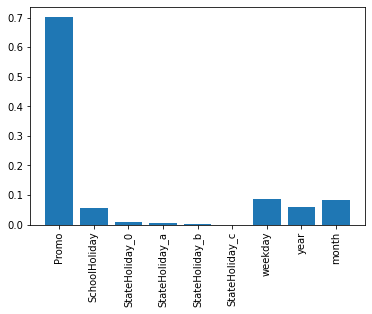

In [19]:
import matplotlib.pyplot as plt 
plt.bar(imp_df['var'], imp_df['imp'])
plt.xticks(rotation=90)
plt.show()

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(xgb, train[input_var], train['Sales'], scoring='neg_mean_squared_error', cv=3)

array([ -7442398.68110158, -10165475.69817356,  -7896996.52747543])

In [22]:
cross_val_score(xgb, train[['Promo', 'weekday', 'month', 'year', 'SchoolHoliday']], train['Sales'], scoring='neg_mean_squared_error', cv=3)

array([ -7437417.60656606, -10109891.53781048,  -7579785.74399885])

In [23]:
import numpy as np 

In [24]:
score_list=[]
selected_varnum=[]

In [25]:
for i in range(1, 10):
    selected_var = imp_df['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, train[selected_var], train['Sales'], scoring='neg_mean_squared_error', cv=3)
    score_list.append(-np.mean(scores))
    selected_varnum.append(i)
    print(i)

1
2
3
4
5
6
7
8
9


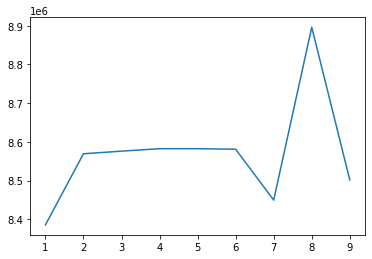

In [26]:
plt.plot(selected_varnum, score_list)

In [27]:
cross_val_score(xgb, train[['Promo', 'weekday']], train['Sales'], scoring='neg_mean_squared_error', cv=3)

array([ -7241548.38898523, -10134534.97381444,  -7116067.92521244])

In [28]:
xgb.fit(train[['Promo', 'weekday']], train['Sales'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=2021,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
test['Sales'] = xgb.predict(test[['Promo', 'weekday']])

In [30]:
test[['id', 'Sales']].to_csv('submission.csv', index=False)

# 5. Store 데이터 활용

In [31]:
train = pd.merge(train, store, on=['Store'], how='left')
test = pd.merge(test, store, on=['Store'], how='left')

In [32]:
train['CompetitionOpen'] = 12*(train['year'] - train['CompetitionOpenSinceYear']) + (train['month'] - train['CompetitionOpenSinceMonth'])
test['CompetitionOpen'] = 12*(test['year'] - test['CompetitionOpenSinceYear']) + (test['month'] - test['CompetitionOpenSinceMonth'])

In [33]:
train['WeekOfYear'] = train['Date'].dt.weekofyear
test['WeekOfYear'] = train['Date'].dt.weekofyear

<ipython-input-33-46359de9ee00>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train['WeekOfYear'] = train['Date'].dt.weekofyear
<ipython-input-33-46359de9ee00>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test['WeekOfYear'] = train['Date'].dt.weekofyear


In [34]:
train['PromoOpen'] = 12 * ( train['year'] - train['Promo2SinceYear'] ) + (train['WeekOfYear'] - train['Promo2SinceWeek']) / 4
test['PromoOpen'] = 12 * ( test['year'] - test['Promo2SinceYear'] ) + (test['WeekOfYear'] - test['Promo2SinceWeek']) / 4

In [35]:
train = pd.get_dummies(columns=['StoreType', 'Assortment','PromoInterval'], data=train)
test = pd.get_dummies(columns=['StoreType', 'Assortment', 'PromoInterval'], data=test)

# 6. 2차 모델링

In [36]:
train.columns

Index(['id', 'Store', 'Date', 'Sales', 'Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec'],
      dtype='object')

In [37]:
## 2차 모델링을 위한 input 변수를 지정합니다.
input_var = ['Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month', 'CompetitionDistance',
       'Promo2',
       'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec']

In [38]:
## 지정한 input 변수로 xgb 모델을 학습시킵니다.
xgb = XGBRegressor( n_estimators=300, learning_rate= 0.1, random_state=2020)
xgb.fit(train[input_var],train['Sales'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
## 학습된 모델에서 변수중요도를 뽑아 imp_df라는 데이터프레임으로 저장시킵니다. 
imp_df = pd.DataFrame({'var':input_var,
                       'imp':xgb.feature_importances_})
imp_df = imp_df.sort_values(['imp'],ascending=False)

In [40]:
score_list=[]
selected_varnum=[]

In [41]:
## 변수중요도가 중요한 순서대로 input 변수를 늘려가며 cross validation을 실행시킵니다.
## cross validation 결과물을 score_list에 저장합니다.
for i in range(1,25):
    selected_var = imp_df['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb, 
                             train[selected_var], 
                             train['Sales'], 
                             scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    selected_varnum.append(i)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


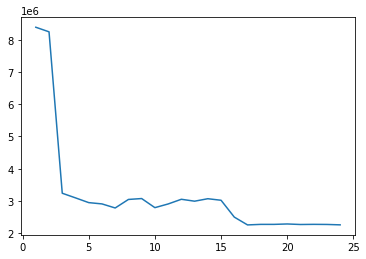

In [42]:
## 선택 변수에 따른 cross validation score를 시각화해봅니다.
plt.plot(selected_varnum, score_list)

In [43]:
## 최적이라고 나온 17개의 변수를 선택해 모델을 학습하고 예측해 제출파일로 저장합니다.
input_var = imp_df['var'].iloc[:17].tolist()
xgb.fit(train[input_var],
        train['Sales'])

test['Sales'] = xgb.predict(test[input_var])

test[['id','Sales']].to_csv("submission2.csv",index=False)

# 7. 파라미터 튜닝

In [44]:
## n_estimators 파라미터를 최적화시키는 작업을 진행합니다.
estim_list = [100,200,300,400,500,600,700,800,900]
score_list = []

In [45]:
for i in estim_list:
    xgb = XGBRegressor( n_estimators=i, learning_rate= 0.1, random_state=2020)
    scores = cross_val_score(xgb, train[input_var], train['Sales'], scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    print(i)

100
200
300
400
500
600
700
800
900


(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

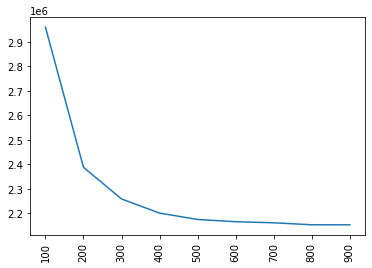

In [46]:
plt.plot(estim_list,score_list)
plt.xticks(rotation=90)

In [47]:
xgb = XGBRegressor( n_estimators=600, learning_rate= 0.1, random_state=2020)

In [48]:
xgb.fit(train[input_var],
        train['Sales'])

test['Sales'] = xgb.predict(test[input_var])

test[['id','Sales']].to_csv("submission3.csv",index=False)